In [65]:
import asyncio
import aiohttp
import aiomoex
import pandas as pd
from datetime import datetime, timedelta
import sqlite3
import nest_asyncio
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, AutoDateLocator

warnings.filterwarnings("ignore")

nest_asyncio.apply()

class MoexDataRetrival():
    
    def __init__(self, start_date : str, end_date : str):
        self.start_date = start_date
        self.end_date = end_date

    #get a stock list from MOEX exchange
    async def get_stock_list(self) -> pd.DataFrame:
        request_url = "https://iss.moex.com/iss/engines/stock/" "markets/shares/boards/TQBR/securities.json"
        arguments = {
            "securities.columns": (
                "SECID,"
                "REGNUMBER,"
                "LOTSIZE,"
                "SHORTNAME,"
                "BOARDID,"
                "LISTLEVEL,"
                "ISIN,"
                "ISSUECAPITALIZATION,"
                "FACEVALUE,"
                "ISSUESIZE,"
            )
        }
        async with aiohttp.ClientSession() as session:
            iss = aiomoex.ISSClient(session, request_url, arguments)
            data = await iss.get()
            data = pd.DataFrame(data["securities"])
            return data['SECID']

    #get a stock list from MOEX exchange
    async def get_stock_list_with_extra_data(self) -> pd.DataFrame:
        request_url = "https://iss.moex.com/iss/engines/stock/" "markets/shares/boards/TQBR/securities.json"
        arguments = {
            "securities.columns": (
                "SECID,"
                "REGNUMBER,"
                "LOTSIZE,"
                "SHORTNAME,"
                "BOARDID,"
                "LISTLEVEL,"
                "ISIN,"
                "ISSUECAPITALIZATION,"
                "FACEVALUE,"
                "ISSUESIZE,"
            )
        }
        async with aiohttp.ClientSession() as session:
            iss = aiomoex.ISSClient(session, request_url, arguments)
            data = await iss.get()
            data = pd.DataFrame(data["securities"])
            return data

    #get a price history for the ticker in TQBR regime  
    
    async def get_price_history(self, ticker : str) -> pd.DataFrame:
        async with aiohttp.ClientSession() as session:
            columns=[
                    "BOARDID", "TRADEDATE", "SHORTNAME", "SECID", "NUMTRADES",
                    "VALUE", "OPEN", "LOW", "HIGH", "LEGALCLOSEPRICE",
                    "WAPRICE", "CLOSE", "VOLUME", "MARKETPRICE2", "MARKETPRICE3",
                    "ADMITTEDQUOTE", "MP2VALTRD", "MARKETPRICE3TRADESVALUE",
                    "ADMITTEDVALUE", "WAVAL"
                ]
            data = await aiomoex.get_board_history(session, ticker,columns = columns,start = self.start_date, end = self.end_date)
            df = pd.DataFrame(data)
            return df

    #get a price history for the ticker in TQBR regime  
    async def get_multiple_price_histories(self, tickers : pd.Series) -> pd.DataFrame:
        tasks = [self.get_price_history(ticker) for ticker in tickers]
        results = await asyncio.gather(*tasks)
        combined_df = pd.concat(results, ignore_index=True)
        combined_df['TRADEDATE'] = pd.to_datetime(combined_df['TRADEDATE'])
        condition = (combined_df['SECID'] == 'GMKN') & (combined_df['TRADEDATE'] <= '2024-04-01')
        combined_df.loc[condition, 'CLOSE'] = combined_df.loc[condition, 'CLOSE'] / 100
        condition = (combined_df['SECID'] == 'TRNFP') & (combined_df['TRADEDATE'] <= '2024-02-14')
        combined_df.loc[condition, 'CLOSE'] = combined_df.loc[condition, 'CLOSE'] / 100
        return combined_df


    #check the stocks which are trading near min for the last n years
    def get_tickers_which_we_can_buy_now(self, df : pd.DataFrame, years : int, percent : float):

        # Ensure TRADEDATE is in datetime format
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
        # Calculate date n years ago
        today = datetime.now()
        n_years_ago = today - timedelta(days=years*365)

        # Filter data for the last n years
        df_last_n_years = df[df['TRADEDATE'] >= n_years_ago]

        # Calculate the minimum and maximum closing price for each ticker over the last 2 years
        min_prices = df_last_n_years.groupby('SECID')['CLOSE'].min().reset_index()
        min_prices.rename(columns={'CLOSE': 'MIN_CLOSE'}, inplace=True)
        max_prices = df_last_n_years.groupby('SECID')['CLOSE'].max().reset_index()
        max_prices.rename(columns={'CLOSE': 'MAX_CLOSE'}, inplace=True)

        # Get the latest closing price for each ticker
        latest_prices = df_last_n_years.sort_values('TRADEDATE').groupby('SECID').tail(1).reset_index()
        latest_prices = latest_prices[['SECID', 'CLOSE']].rename(columns={'CLOSE': 'LATEST_CLOSE'})

        # Merge the minimum, maximum, and latest prices
        merged_df = pd.merge(min_prices, max_prices, on='SECID')
        merged_df = pd.merge(merged_df, latest_prices, on='SECID')

        # Filter tickers where the latest closing price is not higher than x% above the minimum price
        condition = merged_df['LATEST_CLOSE'] <= merged_df['MIN_CLOSE'] * (1+percent/100)
        result = merged_df[condition]

        return result
    
    
class BiddingResultsDBLoader():
    
    #main table name - это название основной таблицы где лежат итоги торгов
    def __init__(self, path_to_db : str, main_table_name : str):
        
        self.path_to_db = path_to_db
        self.main_table_name = main_table_name
        
    #remove duplicates from table
    def remove_duplicates(self):
        """
        Connects to an SQLite database and removes duplicate rows from the specified table.

        Parameters:
        database_path (str): The path to the SQLite database file.
        table_name (str): The name of the table from which to remove duplicates.
        """
        # Connect to the SQLite database
        conn = sqlite3.connect(self.path_to_db)
        cursor = conn.cursor()

        # Define the query to remove duplicates
        delete_duplicates_query = f"""
        WITH duplicates AS (
            SELECT 
                ROWID,
                BOARDID,
                TRADEDATE,
                CLOSE,
                VOLUME,
                VALUE,
                SECID,
                ROW_NUMBER() OVER (PARTITION BY BOARDID, TRADEDATE, SECID ORDER BY ROWID) AS rn
            FROM 
                {self.main_table_name}
        )
        DELETE FROM {self.main_table_name}
        WHERE ROWID IN (
            SELECT ROWID
            FROM duplicates
            WHERE rn > 1
        );
        """

        try:
            # Execute the query to delete duplicates
            cursor.execute(delete_duplicates_query)
            # Commit the transaction
            conn.commit()
        except sqlite3.Error as error:
            print(f"Error while removing duplicates: {error}")
        finally:
            # Close the connection
            conn.close()



    def insert_data_to_database(self, df : pd.DataFrame):
        conn = sqlite3.connect(self.path_to_db)
        df.to_sql(self.main_table_name, conn, if_exists='append', index=False)
        self.remove_duplicates()
        conn.close()
        
    def GetBiddindTableData(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = "SELECT * FROM " + self.main_table_name
        bidding_data = pd.read_sql_query(query, conn)
        conn.close()
        return bidding_data
    
    def GetDeals(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = "SELECT * FROM DEALS"
        deals = pd.read_sql_query(query, conn)
        conn.close()
        return deals
    
    def GetDataForReturns(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = f"""WITH joined_data AS (
    SELECT 
        m.TRADEDATE,
        m.SECID,
        m.CLOSE,
        COALESCE(d.DEVIDEND,0) DEVIDEND,
        CASE
            WHEN d.DIRECTION <> 'BUY'  THEN COALESCE(-d.NUMBER_OF_SHARES,0)
            ELSE COALESCE(d.NUMBER_OF_SHARES,0)
        END AS NUMBER_OF_SHARES,
        
        CASE
            WHEN d.DIRECTION <> 'SELL'  THEN COALESCE(-d.TOTAL_VOLUME,0) - COALESCE(d.BROKER_COMMISSIONS,0) - COALESCE(d.EXCHANGE_COMMISSIONS,0) + COALESCE(d.DEVIDEND,0)
            ELSE COALESCE(d.TOTAL_VOLUME,0) - COALESCE(d.EXCHANGE_COMMISSIONS,0) + COALESCE(d.DEVIDEND,0)
        END AS TOTAL_VOLUME,
        COALESCE(-d.BROKER_COMMISSIONS,0) BROKER_COMMISSIONS,
        COALESCE(-d.EXCHANGE_COMMISSIONS,0) EXCHANGE_COMMISSIONS
        
    FROM 
        moexdata m
    LEFT JOIN 
        deals d 
    ON 
        DATE(m.TRADEDATE) = DATE(d.TRADEDATE) AND m.SECID = d.SECID
),
cumulative_sums AS (
    SELECT
        TRADEDATE,
        SECID,
        NUMBER_OF_SHARES,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS cumulative_number_of_shares,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE,SECID) * CLOSE AS NPV,
        SUM(TOTAL_VOLUME) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS CASH_BALANCE,
        LAG(CLOSE) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS PREVIOUS_CLOSE,
        CLOSE,
        DEVIDEND,
        TOTAL_VOLUME as CASH_FLOW,
        BROKER_COMMISSIONS,
        EXCHANGE_COMMISSIONS
    FROM
        joined_data
)
SELECT 
    TRADEDATE,
    SECID,
    cumulative_number_of_shares,
    CLOSE,
    PREVIOUS_CLOSE,
    CASH_FLOW,
    DEVIDEND,
    CASH_BALANCE,
    cumulative_number_of_shares * CLOSE as NPV,
    COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0) AS PREVIOUS_NPV,
    CASH_FLOW + (cumulative_number_of_shares * CLOSE - COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0)) AS PnL

    
FROM 
    cumulative_sums where  DATE(TRADEDATE) > '2024-05-24' and SECID in (select distinct SECID from DEALS);"""
    
        for_returns = pd.read_sql_query(query, conn)
        conn.close()
        return for_returns

    def GetEndValue(self,end_date) -> float:
        conn = sqlite3.connect(self.path_to_db)
        query = f"""WITH joined_data AS (
    SELECT 
        m.TRADEDATE,
        m.SECID,
        m.CLOSE,
        CASE
            WHEN d.DIRECTION <> 'BUY'  THEN COALESCE(-d.NUMBER_OF_SHARES,0)
            ELSE COALESCE(d.NUMBER_OF_SHARES,0)
        END AS NUMBER_OF_SHARES,
        
        CASE
            WHEN d.DIRECTION <> 'SELL'  THEN COALESCE(-d.TOTAL_VOLUME,0)
            ELSE COALESCE(d.TOTAL_VOLUME,0)
        END AS TOTAL_VOLUME,
        COALESCE(-d.BROKER_COMMISSIONS,0) BROKER_COMMISSIONS,
        COALESCE(-d.EXCHANGE_COMMISSIONS,0) EXCHANGE_COMMISSIONS
        
    FROM 
        moexdata m
    LEFT JOIN 
        deals d 
    ON 
        DATE(m.TRADEDATE) = DATE(d.TRADEDATE) AND m.SECID = d.SECID
),
cumulative_sums AS (
    SELECT
        TRADEDATE,
        SECID,
        NUMBER_OF_SHARES,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS cumulative_number_of_shares,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) * CLOSE AS NPV,
        SUM(TOTAL_VOLUME) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS CASH_BALANCE,
        LAG(CLOSE) OVER (PARTITION BY SECID PARTITION BY SECID ORDER BY TRADEDATE) AS PREVIOUS_CLOSE,
        CLOSE,
        TOTAL_VOLUME as CASH_FLOW,
        BROKER_COMMISSIONS,
        EXCHANGE_COMMISSIONS
    FROM
        joined_data
)

SELECT SUM(NPV) as NPV FROM (

SELECT 
    TRADEDATE,
    SECID,
    cumulative_number_of_shares,
    CLOSE,
    PREVIOUS_CLOSE,
    CASH_FLOW,
    CASH_BALANCE,
    cumulative_number_of_shares * CLOSE as NPV,
    COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0) AS PREVIOUS_NPV,
    BROKER_COMMISSIONS,
    EXCHANGE_COMMISSIONS,
    CASH_FLOW + (cumulative_number_of_shares * CLOSE - COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0)) + BROKER_COMMISSIONS + EXCHANGE_COMMISSIONS AS PnL

    
FROM 
    cumulative_sums where  DATE(TRADEDATE) > '2024-05-24' and SECID in (select distinct SECID from DEALS))
    
    WHERE DATE(TRADEDATE) = """ + "'" + end_date + "';"
    
        for_returns = pd.read_sql_query(query, conn)
        conn.close()
        return float(for_returns['NPV'].iloc[0])
    
    
class GetReturns():
    
    def __init__(self, data : pd.DataFrame):
        self.data = data
        self.data['TRADEDATE'] = pd.to_datetime(self.data['TRADEDATE'])
        
    def EndNPVValue(self, date : str) -> float:
        return self.data.loc[self.data['TRADEDATE'] == date, 'NPV'].sum()

class ReturnCalculator():
    
    def __init__(self, begin_value : float, period_start : str):
        
        self.begin_value = begin_value
        self.period_start = period_start
        
    def modified_dietz(self,end_value, cash_flows, cash_flow_dates, period_end):
        """
        Calculate the Modified Dietz return.

        Parameters:
        begin_value (float): Portfolio value at the beginning of the period.
        end_value (float): Portfolio value at the end of the period.
        cash_flows (list): List of cash flows during the period.
        cash_flow_dates (list): Corresponding dates of the cash flows.
        period_start (datetime): Start date of the period.
        period_end (datetime): End date of the period.

        Returns:
        float: Modified Dietz return.
        """

        # Ensure dates are in datetime format
        period_start = pd.to_datetime(self.period_start)
        period_end = pd.to_datetime(period_end)
        cash_flow_dates = pd.to_datetime(cash_flow_dates)

        # Calculate the weights for each cash flow
        weights = [(period_end - date).days / (period_end - period_start).days for date in cash_flow_dates]

        # Calculate the numerator (change in portfolio value adjusted for cash flows)
        numerator = end_value - self.begin_value - sum(cash_flows)

        # Calculate the denominator (beginning value adjusted for weighted cash flows)
        denominator = self.begin_value + sum(cf * w for cf, w in zip(cash_flows, weights))

        return numerator / denominator

    
def plot_returns(df):
    
    
    data = df

    df = pd.DataFrame(data)

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Set the style using seaborn
    sns.set(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Formatting the date on the x-axis
    date_form = DateFormatter("%Y-%m-%d")
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.set_xticks(df['date'])

    # Plot the area under the curve
    plt.fill_between(df['date'], df['return'], where=(df['return'] >= 0), interpolate=True, color='green', alpha=0.2)
    plt.fill_between(df['date'], df['return'], where=(df['return'] < 0), interpolate=True, color='red', alpha=0.2)

    # Plot the returns
    #sns.lineplot(data=df, x='date', y='return', color='blue', linewidth=2.5)
    plt.plot(df['date'], df['return'], color='blue', linewidth=2.5)

    # Highlight negative returns in red and positive returns in green
    for i in range(1, len(df)):
        if df['return'].iloc[i] < 0:
            plt.plot(df['date'].iloc[i-1:i+1], df['return'].iloc[i-1:i+1], color='red', linewidth=2)
        else:
            plt.plot(df['date'].iloc[i-1:i+1], df['return'].iloc[i-1:i+1], color='green', linewidth=2)

    # Adding title and labels
    plt.title('Portfolio return including dividend payments and commissions', fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Return in (%)', fontsize=12)

    
    # Adding grid for better readability
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.3)

    # Adding legend
    #plt.legend(['Positive Return', 'Negative Return'], loc='upper left', fontsize=12)

    # Show plot
    plt.show()   


In [25]:
moex_data_loader = MoexDataRetrival('2024-06-03','2024-06-03')
stock_list = asyncio.run(moex_data_loader.get_stock_list())
trade_data = asyncio.run(moex_data_loader.get_multiple_price_histories(stock_list))

db_loader = BiddingResultsDBLoader('/Users/antonvolkov/Desktop/MoexTrading/MoexData.db','MOEXDATA')
db_loader.insert_data_to_database(trade_data)


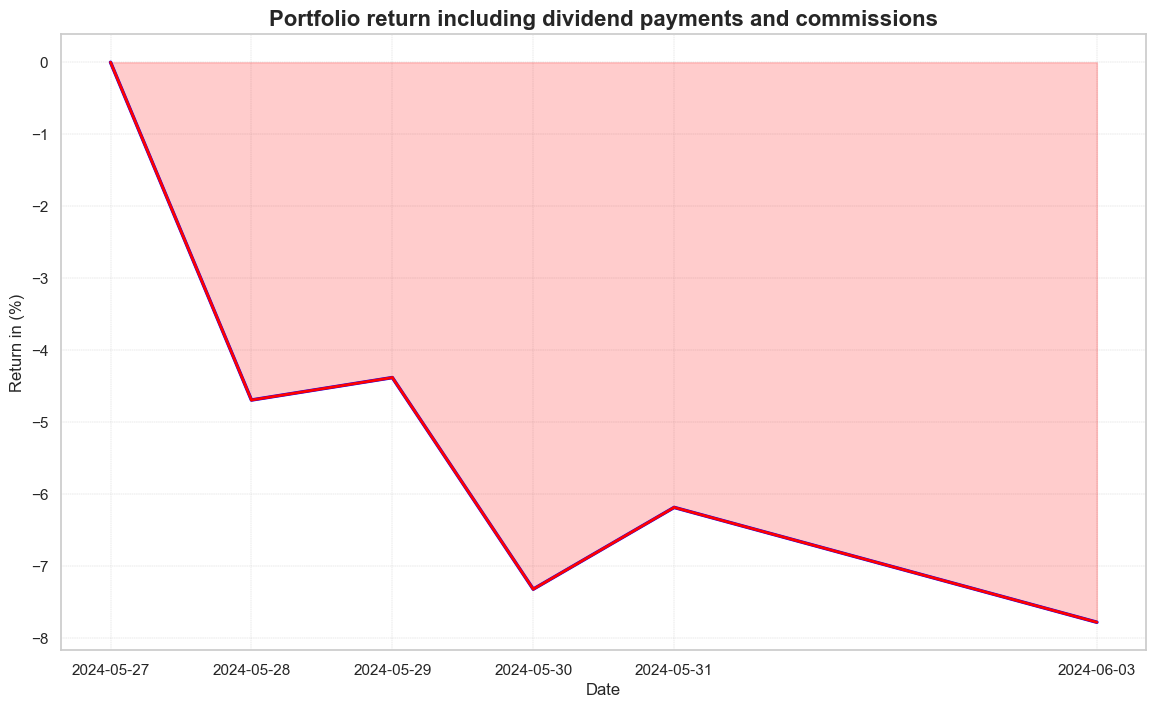

In [91]:
#get needed data
db_loader = BiddingResultsDBLoader('/Users/antonvolkov/Desktop/MoexTrading/MoexData.db','MOEXDATA')
for_returns = db_loader.GetDataForReturns()
returns_analysis = GetReturns(for_returns)
returns_calculator = ReturnCalculator(0,'2024-05-27')

cash_flow_by_date = for_returns.groupby('TRADEDATE', as_index=False)['CASH_FLOW'].sum()
end_npv_by_date = for_returns.groupby('TRADEDATE', as_index=False)['NPV'].sum()
cash_flows_list = [-cf for cf in cash_flow_by_date['CASH_FLOW']] # Positive for deposits, negative for withdrawals
cash_flow_dates_list = for_returns['TRADEDATE'].drop_duplicates().tolist() # dates, we need daily


resulting_reurns_df = pd.DataFrame(columns=['date', 'return'])
resulting_reurns_df = resulting_reurns_df.append({'date': '2024-05-27', 'return': 0.001}, ignore_index=True)
date_number = 1
for date in cash_flow_dates_list:
    if date != cash_flow_dates_list[0]:
        date_number = date_number + 1
        period_end = date
        #end_npv = returns_analysis.EndNPVValue(period_end)
        end_npv = end_npv_by_date.loc[end_npv_by_date['TRADEDATE'] == date, 'NPV'].sum()
        tradedate = date
        todays_return = returns_calculator.modified_dietz(end_npv, cash_flows_list[0:date_number], 
                                      cash_flow_dates_list[0:date_number], period_end) * 100
        resulting_reurns_df = resulting_reurns_df.append({'date': date, 'return': todays_return}, ignore_index=True)
        
        
plot_returns(resulting_reurns_df)

In [90]:
resulting_reurns_df

,date,return
0,2024-05-27,0.001000
1,2024-05-28,-4.689468
2,2024-05-29,-4.377875
3,2024-05-30,-7.315757
4,2024-05-31,-6.180666
5,2024-06-03,-7.775286
